In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

FASTQ_FILE = "../dataset/SRR33470049.fastq"
REF_FASTA = "../references/Mus_musculus.GRCm39.dna_sm.primary_assembly.fa"
REF_INDEX = "../references/genome.mmi"
GTF = "../references/Mus_musculus.GRCm39.109.gtf"

ALIGN_DIR = "../results/alignment/"
os.makedirs(ALIGN_DIR, exist_ok=True)

BED_FILE = os.path.join(ALIGN_DIR, "aligned.bed")
SAM_FILE = os.path.join(ALIGN_DIR, "aligned.sam")
BAM_FILE = os.path.join(ALIGN_DIR, "aligned.bam")
SORTED_BAM = os.path.join(ALIGN_DIR, "aligned.sorted.bam")

The above mostly just sets up the pathing/directories for all the files. Makes it easier to references all of these later.

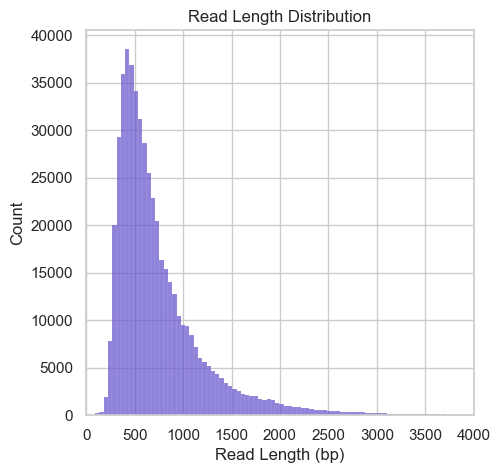

In [12]:
def read_fastq_lengths(fastq_path):
    lengths = []
    with open(fastq_path, 'r') as f:
        for i, line in enumerate(f):
            if i % 4 == 1:
                lengths.append(len(line.strip()))
    return lengths

lengths = read_fastq_lengths(FASTQ_FILE)

plt.figure(figsize=(5, 5))
sns.histplot(lengths, bins=500, color='slateblue')
plt.title("Read Length Distribution")
plt.xlim(0, 4000)
plt.xlabel("Read Length (bp)")
plt.ylabel("Count")
plt.show()

This code just opens the fastq file, goes line by line, and returns the average length. Tried making the graph as good as possible.
Shows the mean quite well this way -- 757 bp for mine.

Also did some QC using NanoPlot but that was done in terminal, will add the jupyter notebook cells for that but I included the QC report in this repo.

In [4]:
print(f"Total reads: {len(lengths)}")
print(f"Mean read length: {sum(lengths)/len(lengths):.2f} bp")

Total reads: 510727
Mean read length: 757.10 bp


In [ ]:
!minimap2 -d {REF_INDEX} {REF_FASTA}

In [5]:
!minimap2 -ax splice -uf --secondary=no -t 4 {REF_INDEX} {FASTQ_FILE} > {SAM_FILE}

[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::5.700*0.88] loaded/built the index for 61 target sequence(s)
[M::mm_mapopt_update::8.060*0.85] mid_occ = 598
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 61
[M::mm_idx_stat::9.537*0.84] distinct minimizers: 97791701 (39.85% are singletons); average occurrences: 5.142; average spacing: 5.426; total length: 2728222451
[M::worker_pipeline::1600.087*0.82] mapped 510727 sequences
[M::main] Version: 2.30-r1287
[M::main] CMD: minimap2 -ax splice -uf --secondary=no -t 4 ../references/genome.mmi ../dataset/SRR33470049.fastq
[M::main] Real time: 1600.791 sec; CPU: 1308.580 sec; Peak RSS: 3.418 GB


This step will take a while, but it basically is taking raw RNA read sequences and figuring out where in the genome they came from. Reads our raw RNA read sequence, compares to the reference genome we picked earlier, and outputs the best location.

In [2]:
!samtools view -bS {SAM_FILE} > {BAM_FILE}
!samtools sort {BAM_FILE} -o {SORTED_BAM}
!samtools index {SORTED_BAM}

Basically makes it easier for the later steps to use the above data, converts the file format from sam (a plain text alignment) to bam (a binary compressed format). Then we sort the above for tools like FLAIR (used later here). Same region mappings are grouped together. Lastly, we create a sort_bam (bai/index file) that just gives us a table of contents or random access to parts of the above file.

In [3]:
!samtools flagstat {SORTED_BAM}

602473 + 0 in total (QC-passed reads + QC-failed reads)
510727 + 0 primary
0 + 0 secondary
91746 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
547012 + 0 mapped (90.79% : N/A)
455266 + 0 primary mapped (89.14% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Gives us a little bit more info on the above BAI.

In [2]:
# FLAIR output
FLAIR_DIR = "../results/flair"
os.makedirs(FLAIR_DIR, exist_ok=True)

Me setting up my director for the flair directory.

In [3]:
!bedtools bamtobed -bed12 -i ../results/alignment/aligned.bam > ../results/alignment/aligned.bed

Converted the bam file to a bed12 file for flair since it was having issues earlier lol.

In [6]:
!flair correct \
  -q {BED_FILE} \
  -g {REF_FASTA} \
  -f {GTF} \
  -o {FLAIR_DIR}/flair_corrected

/Users/s1ffre/miniconda3/envs/flair_work_pls/lib/python3.12/site-packages/ncls/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/s1ffre/miniconda3/envs/flair_work_pls/lib/python3.12/site-packages/ncls/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/s1ffre/miniconda3/envs/flair_work_pls/lib/python3.12/site-packages/ncls/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Ref

Correct in FLAIR basically cleans up and improve the alignments of our long RNA reads by comparing them to known gene structures. Takes each rough alignment, compares to the genome, then the annotation file (gtf) of known gene structures. Our aligner earlier (minimap2) somewhat guesses the read, in areas like the splice site. Therefore we take our annotation, snap splice junctions to the nearest correct site, filter our poorly aligned reads, correct the exon/intron boundaries. This hopefully decreases the alignment noise.

In [3]:
!flair collapse \
  -g {REF_FASTA} \
  -r {"../dataset/SRR33470049.fastq"} \
  -q {FLAIR_DIR}/flair_corrected_all_corrected.bed \
  -f {GTF} \
  -o {FLAIR_DIR}/flair_collapsed

Writing temporary files to /var/folders/pc/0_6d1f7d5j765q5qfcgmpqj00000gn/T/tmpj2shx434/	
collapse_isoforms_precise.py -q ../results/flair/flair_corrected_all_corrected.bed -t 4 -m 2 -w 100 -n none -o ../results/flair/flair_collapsed.firstpass.unfiltered.bed -f ../references/Mus_musculus.GRCm39.109.gtf
Renaming isoforms using gtf
Aligning reads to first-pass isoform reference
Aligning reads to firstpass transcripts
Counting supporting reads for firstpass transcripts
minimap2 -a -t 4 -N 4 --MD ../results/flair/flair_collapsed.firstpass.fa ../dataset/SRR33470049.fastq
count_sam_transcripts.py --sam - -o ../results/flair/flair_collapsed.firstpass.q.counts -t 4 --quality 0 -w 100
Filtering isoforms by read coverage
Flair collapse took 1 minutes and 33 seconds and finished without issues.

FLAIR HAS FINISHED


Now that the alignment should be better after some correction, we build up the actual isoforms. Group similar reads together, turns those into transcripts, and gives us the actual isoforms.

In [13]:
with open("manifest.tsv") as f:
    for line in f:
        print(repr(line))

import os
print("manifest.tsv exists?", os.path.isfile("manifest.tsv"))

with open("manifest.tsv", "r") as f:
    for i, line in enumerate(f):
        parts = line.strip().split("\t")
        print(f"Line {i+1}: {len(parts)} columns -> {parts}")

'SRR33470049\tnocondition\tnobatch\t../dataset/SRR33470049.fastq'
manifest.tsv exists? True
Line 1: 4 columns -> ['SRR33470049', 'nocondition', 'nobatch', '../dataset/SRR33470049.fastq']


Had some issues with the manifest being found, so basically had to make sure it was being found and correctly written.

In [21]:
!flair quantify \
  -r ./manifest.tsv \
  -i {FLAIR_DIR}/flair_collapsed.isoforms.fa \
  -t 4 \
  -o {FLAIR_DIR}/flair_quant

Writing temporary files with prefixes similar to /var/folders/pc/0_6d1f7d5j765q5qfcgmpqj00000gn/T/tmp6imb_in0
Step 1/3. Aligning sample SRR33470049_nobatch, 1/1 
Step 2/3. Quantifying isoforms for sample SRR33470049_nobatch: 1/1 
Step 3/3. Writing counts to ../results/flair/flair_quant.counts.tsv 

Flair quantify took 0 minutes and 51 seconds and finished without issues.

FLAIR HAS FINISHED


Now we 'quantify' how many isoforms are actually present. My understanding is basically how many times does each 'message' show up in our dataset. The output is each row being an isoform, and the count of it. We also get an idea of what is novel/known compared with our original reference. More importantly, we can find the ones with highest expression.

In [28]:
import pandas as pd

counts = pd.read_csv("../results/flair/flair_quant.counts.tsv", sep="\t", header=None)
print("Number of columns:", counts.shape[1])
print(counts.head())

Number of columns: 2
                                       0                                1
0                                    ids  SRR33470049_nocondition_nobatch
1  ENSMUST00000000058_ENSMUSG00000000058                            201.0
2  ENSMUST00000000080_ENSMUSG00000000078                             16.0
3  ENSMUST00000000090_ENSMUSG00000000088                            144.0
4  ENSMUST00000000175_ENSMUSG00000000171                             75.0


In [15]:
import pandas as pd

counts = pd.read_csv("../results/flair/flair_quant.counts.tsv", sep="\t", header=0)
counts.columns = ["transcript_gene", "counts"]
counts[['transcript_id', 'gene_id']] = counts['transcript_gene'].str.split('_', expand=True)
counts['counts'] = counts['counts'].astype(int)
counts.head()

,transcript_gene,counts,transcript_id,gene_id
0,ENSMUST00000000058_ENSMUSG00000000058,201,ENSMUST00000000058,ENSMUSG00000000058
1,ENSMUST00000000080_ENSMUSG00000000078,16,ENSMUST00000000080,ENSMUSG00000000078
2,ENSMUST00000000090_ENSMUSG00000000088,144,ENSMUST00000000090,ENSMUSG00000000088
3,ENSMUST00000000175_ENSMUSG00000000171,75,ENSMUST00000000175,ENSMUSG00000000171
4,ENSMUST00000000193_ENSMUSG00000035385,3,ENSMUST00000000193,ENSMUSG00000035385


In [16]:
known_isoforms = counts[counts['transcript_id'].str.startswith('ENS')]
novel_isoforms = counts[~counts['transcript_id'].str.startswith('ENS')]

counts['isoform_type'] = counts['transcript_id'].apply(
    lambda x: 'known' if x.startswith('ENSMUST') else 'novel'
)

# Show the count of both the novel/known isoforms from the aboev step
print(counts['isoform_type'].value_counts())

isoform_type
novel    11394
known     4272
Name: count, dtype: int64


                count       mean         std  min  25%   50%   75%     max
isoform_type                                                              
known          4272.0  38.118914  128.747728  1.0  7.0  15.0  33.0  6255.0
novel         11394.0  16.163683   77.989310  1.0  4.0   7.0  12.0  3586.0


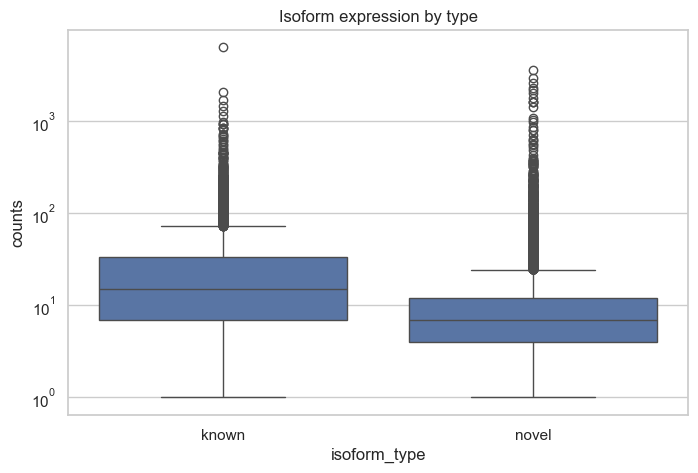

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary stats
print(counts.groupby('isoform_type')['counts'].describe())

# Plot distributions
plt.figure(figsize=(8,5))
sns.boxplot(x='isoform_type', y='counts', data=counts)
plt.yscale('log')  # Counts often vary a lot
plt.title('Isoform expression by type')
plt.savefig('isoform_expression_by_type')
plt.show()

Graph it all out, in this case, we have 11394.0 novel and 4272.0 known. For the known, each one had roughly 38 reads on average supporting it, highest express had 6255 reads, and the median was roughly 15. For the novel, each one had roughly 16 reads on average supporting it, highest express had 3586 reads, and the median was pretty low with 50% having 7 or fewer reads. Curiously large amount of new isoforms in mouse brown fat and some where highly expressed! May be interesting!!! If my understanding is correct and the limitations are acknowledged, this dataset brown fat could express many previously unreported isoforms.

In [18]:
high_exp_novel = counts[(counts['isoform_type'] == 'novel') & (counts['counts'] > 100)]
print(high_exp_novel)

                            transcript_gene  counts       transcript_id  \
4370            SRR33470049.103477_MT:15000     173  SRR33470049.103477   
4453         SRR33470049.107081_X:108205000     102  SRR33470049.107081   
4500   SRR33470049.10902_ENSMUSG00000062353     122   SRR33470049.10902   
4613          SRR33470049.113587_8:69357000     254  SRR33470049.113587   
4635          SRR33470049.114391_3:86579000     199  SRR33470049.114391   
...                                     ...     ...                 ...   
15350         SRR33470049.88432_1:172100000     103   SRR33470049.88432   
15380   SRR33470049.8953_ENSMUSG00000115783     706    SRR33470049.8953   
15451   SRR33470049.9226_ENSMUSG00000041653     123    SRR33470049.9226   
15491   SRR33470049.9375_ENSMUSG00000042312     117    SRR33470049.9375   
15612          SRR33470049.98108_6:88802000     121   SRR33470049.98108   

                  gene_id isoform_type  
4370             MT:15000        novel  
4453          X:1

Only show the ones with over 100 count.

In [19]:
novel_isoforms = counts[counts['isoform_type'] == 'novel']
novel_genes = novel_isoforms['gene_id'].unique()
print(f"Number of genes with novel isoforms: {len(novel_genes)}")
print("Example gene IDs:", novel_genes[:10])

Number of genes with novel isoforms: 10482
Example gene IDs: ['13:99123000' '5:124256000' 'ENSMUSG00000019929' '11:106139000'
 'ENSMUSG00000028010' '10:12884000' '17:28294000' '19:54021000'
 '11:53247000' '11:105949000']


Out of all the genes in this dataset, 10482 genes have at least one isoform that doesn’t match any known entry in the reference gtf. These are the novel isoforms, possible new versions of known genes or completely unannotated structures. Below we just graph them by count.

In [20]:
novel_counts_per_gene = novel_isoforms.groupby('gene_id').size().reset_index(name='novel_isoform_count')
novel_counts_per_gene = novel_counts_per_gene.sort_values('novel_isoform_count', ascending=False)
print(novel_counts_per_gene.head(10))

                  gene_id  novel_isoform_count
9463   ENSMUSG00000045983                    8
7403   ENSMUSG00000002944                    7
5704          6:119330000                    6
9711   ENSMUSG00000061232                    6
8084   ENSMUSG00000024393                    6
10039  ENSMUSG00000090625                    5
7564   ENSMUSG00000012705                    5
9721   ENSMUSG00000061780                    5
9882   ENSMUSG00000073418                    5
8180   ENSMUSG00000025369                    5


In [21]:
known_isoforms.sort_values('counts', ascending=False).head(10)
novel_isoforms.sort_values('counts', ascending=False).head(10)

,transcript_gene,counts,transcript_id,gene_id,isoform_type
12849,SRR33470049.443843_ENSMUSG00000064357,3586,SRR33470049.443843,ENSMUSG00000064357,novel
8846,SRR33470049.27951_MT:15000,2909,SRR33470049.27951,MT:15000,novel
12321,SRR33470049.42182_ENSMUSG00000064341,2603,SRR33470049.42182,ENSMUSG00000064341,novel
14460,SRR33470049.545_ENSMUSG00000062515,2247,SRR33470049.545,ENSMUSG00000062515,novel
7378,SRR33470049.221763_8:69358000,2158,SRR33470049.221763,8:69358000,novel
7224,SRR33470049.215908_ENSMUSG00000102070,1990,SRR33470049.215908,ENSMUSG00000102070,novel
10556,SRR33470049.34876_MT:12000,1755,SRR33470049.34876,MT:12000,novel
14667,SRR33470049.61644_MT:6000,1620,SRR33470049.61644,MT:6000,novel
9857,SRR33470049.319875_MT:4000,1592,SRR33470049.319875,MT:4000,novel
12691,SRR33470049.437036_ENSMUSG00000101249,1587,SRR33470049.437036,ENSMUSG00000101249,novel


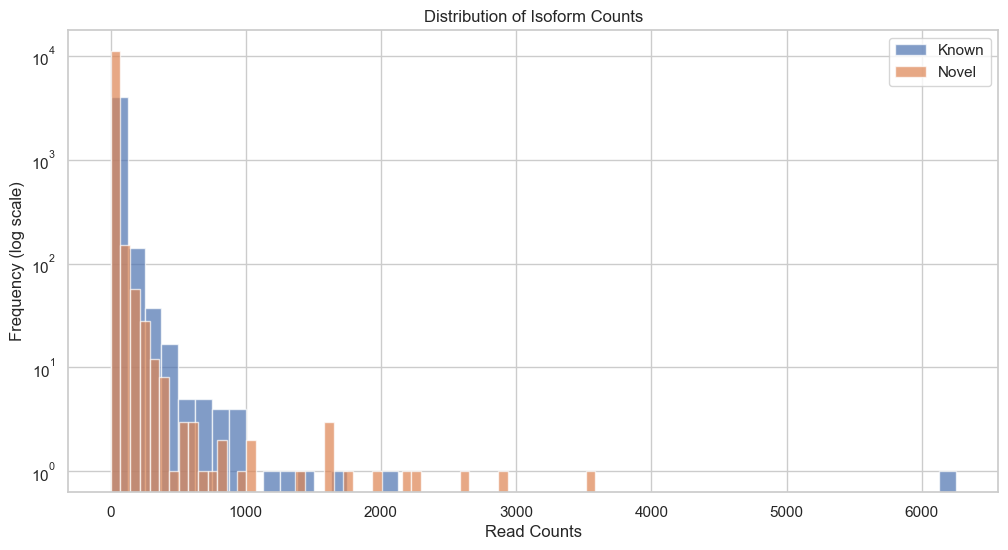

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.hist(known_isoforms['counts'], bins=50, alpha=0.7, label='Known')
plt.hist(novel_isoforms['counts'], bins=50, alpha=0.7, label='Novel')
plt.yscale('log')
plt.xlabel('Read Counts')
plt.ylabel('Frequency (log scale)')
plt.legend()
plt.title('Distribution of Isoform Counts')
plt.savefig('distribution_of_isoform_counts')
plt.show()

In [23]:
top = counts.sort_values(by="counts", ascending=False).head(10)
print(top)

                               transcript_gene  counts         transcript_id  \
1076   ENSMUST00000029076-1_ENSMUSG00000027559    6255  ENSMUST00000029076-1   
12849    SRR33470049.443843_ENSMUSG00000064357    3586    SRR33470049.443843   
8846                SRR33470049.27951_MT:15000    2909     SRR33470049.27951   
12321     SRR33470049.42182_ENSMUSG00000064341    2603     SRR33470049.42182   
14460       SRR33470049.545_ENSMUSG00000062515    2247       SRR33470049.545   
7378             SRR33470049.221763_8:69358000    2158    SRR33470049.221763   
3804     ENSMUST00000173739_ENSMUSG00000002985    2048    ENSMUST00000173739   
7224     SRR33470049.215908_ENSMUSG00000102070    1990    SRR33470049.215908   
10556               SRR33470049.34876_MT:12000    1755     SRR33470049.34876   
980      ENSMUST00000027634_ENSMUSG00000026385    1683    ENSMUST00000027634   

                  gene_id isoform_type  
1076   ENSMUSG00000027559        known  
12849  ENSMUSG00000064357        nove

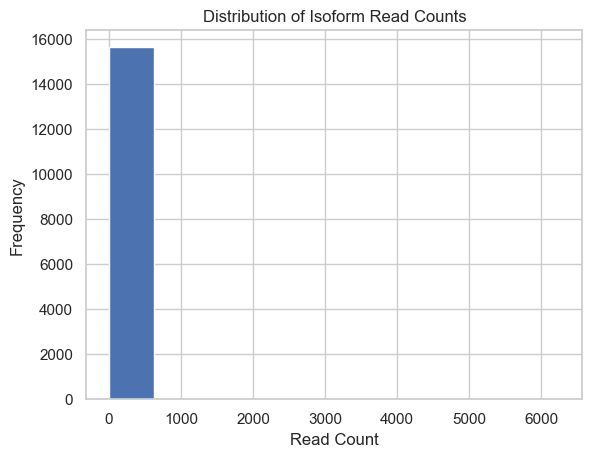

In [28]:
import matplotlib.pyplot as plt

counts['counts'].hist(bins=10)
plt.title("Distribution of Isoform Read Counts")
plt.xlabel("Read Count")
plt.ylabel("Frequency")
plt.show()

In [29]:
import pandas as pd
import gzip

# Parse GTF to extract gene_id ↔ gene_name mapping
def parse_gtf_attributes(attribute_string):
    attributes = {}
    for item in attribute_string.strip().split(';'):
        if item:
            key, value = item.strip().split(' ')
            attributes[key] = value.strip('"')
    return attributes

gene_map = {}

with open(GTF, 'r') as fh:
    for line in fh:
        if line.startswith("#"):
            continue
        fields = line.strip().split('\t')
        if fields[2] == 'gene':
            attr = parse_gtf_attributes(fields[8])
            gene_id = attr.get('gene_id')
            gene_name = attr.get('gene_name')
            if gene_id and gene_name:
                gene_map[gene_id] = gene_name

# Convert to DataFrame
gene_map_df = pd.DataFrame(gene_map.items(), columns=["gene_id", "gene_name"])

Now we will take out GTF file, go line by line and map the prior gene_id to the GTF gene names.

In [30]:
# Merge our early data of novel_isoform_count to the gene map and add the name that we get from the above cell.
merged = novel_counts_per_gene.merge(gene_map_df, on="gene_id", how="left")

# Fill in missing gene names and if there are none, let's just put NA.
merged['gene_name'] = merged['gene_name'].fillna("NA")

# Sort them by isoform_count and display just 10 for now.
merged = merged.sort_values('novel_isoform_count', ascending=False)
merged.head(10)


,gene_id,novel_isoform_count,gene_name
0,ENSMUSG00000045983,8,Eif4g1
1,ENSMUSG00000002944,7,Cd36
2,6:119330000,6,NA
3,ENSMUSG00000061232,6,H2-K1
4,ENSMUSG00000024393,6,Prrc2a
11,ENSMUSG00000036570,5,Fxyd1
14,5:18470000,5,NA
13,ENSMUSG00000032637,5,Atxn2l
12,9:123135000,5,NA
10,ENSMUSG00000024991,5,Eif3a


In [31]:
# Save as CSV for full data
merged.to_csv("novel_isoform_summary.csv", index=False)

# Just gonna take the top 20 for a markdown file to show what we found.
top_20_md = merged.head(20).to_markdown(index=False)
with open("top20_novel_genes.md", "w") as f:
    f.write(top_20_md)

/var/folders/pc/0_6d1f7d5j765q5qfcgmpqj00000gn/T/ipykernel_63187/1977985687.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_n, x='counts', y='gene_name', palette="mako")


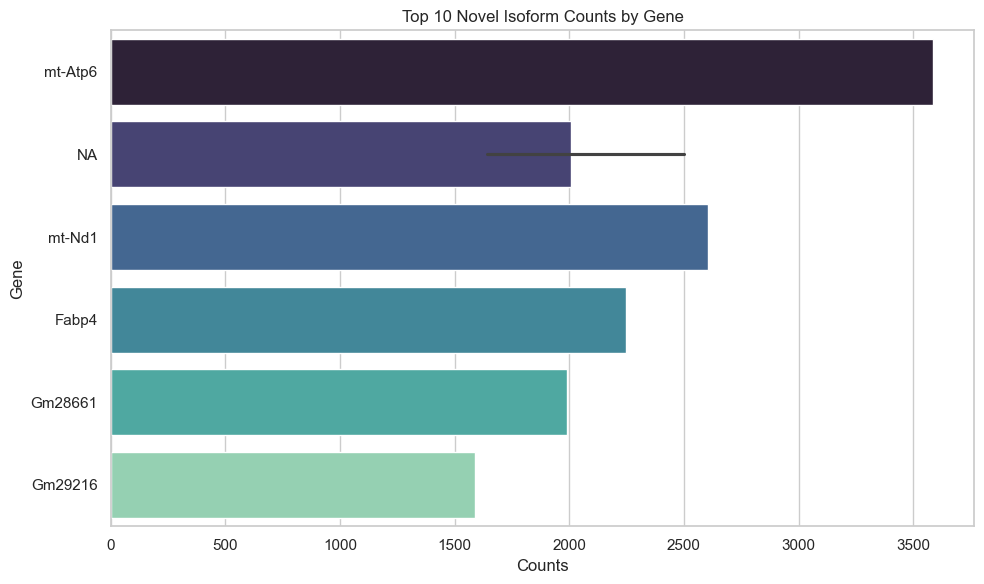

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge original novel isoforms table with gene names
novel_isoforms_named = novel_isoforms.merge(gene_map_df, on="gene_id", how="left")
novel_isoforms_named['gene_name'] = novel_isoforms_named['gene_name'].fillna("NA")

# Plot top 10 expressed novel isoforms
top_n = novel_isoforms_named.sort_values("counts", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_n, x='counts', y='gene_name', palette="mako")
plt.title("Top 10 Novel Isoform Counts by Gene")
plt.xlabel("Counts")
plt.ylabel("Gene")
plt.tight_layout()
plt.savefig('top_10_novel_isoform_counts_by_gene.png')
plt.show()

In [33]:
top_expressed_novels = novel_isoforms.sort_values("counts", ascending=False).head(10)
print(top_expressed_novels[['transcript_id', 'gene_id', 'counts']])

            transcript_id             gene_id  counts
12849  SRR33470049.443843  ENSMUSG00000064357    3586
8846    SRR33470049.27951            MT:15000    2909
12321   SRR33470049.42182  ENSMUSG00000064341    2603
14460     SRR33470049.545  ENSMUSG00000062515    2247
7378   SRR33470049.221763          8:69358000    2158
7224   SRR33470049.215908  ENSMUSG00000102070    1990
10556   SRR33470049.34876            MT:12000    1755
14667   SRR33470049.61644             MT:6000    1620
9857   SRR33470049.319875             MT:4000    1592
12691  SRR33470049.437036  ENSMUSG00000101249    1587


In [34]:
# Check if gene_id contains 'MT' and see if it has relation to mitochondrial genes
mito_novels = novel_isoforms[novel_isoforms['gene_id'].str.contains('MT', na=False)]
print(f"Novel isoforms from mitochondrial genes: {mito_novels.shape[0]}")

Novel isoforms from mitochondrial genes: 30


So yea! That's my mini project for bio-informatics. These could be not novel, my next steps would be looking into RefSeq/GENCODE and do some literature searching. We also only have one sample, which honestly isn't the best here.